In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os

import matplotlib.pyplot as plt
import seaborn as sns
import random

import Utilities
from NaiveTCM import NaiveNetFitness
from PersistenceNetFitnessGlobal import PersistenceNetFitnessGlobal
from PersistenceNetFitness import PersistenceNetFitness
from PersistenceNetFitnesslinks import PersistenceNetFitnesslinks

In [2]:
cd ../Structural Break and Reconstruction Social Networks/temporal_networks_daily

/home/virginio.clemente/Structural Break and Reconstruction Social Networks/temporal_networks_daily


In [3]:
data = []

for file in os.listdir():
    if 'checkpoints' in file: continue
    step = int(file.split('_')[1].split('.')[0])
    matrix = np.genfromtxt(file,delimiter=',')
    G = nx.from_numpy_matrix(matrix)
    data.append([step , G ]) 

data.sort()

tnet_synt_all = Utilities.TemporalNetworkLoaderSynt(data,0,len(data))

pnt_likelihood_TCM = PersistenceNetFitness(tnet_synt_all)

# Reshuflling

In [4]:
vec_h_null = np.zeros(92)

lista_vec_h_null = []
for iterations in range(100):
    def measured_autocorrelation(tgraph,tau):

        no_steps = len(tgraph.data)    
        no_nodes = len(tgraph.data[0][2].nodes()) 

        vec_h = np.zeros(no_nodes)        
        for i_step in range(no_steps+tau -1): 
            
            block_id, current_time , g0 = tgraph.data[ i_step%no_steps ]
            block_id, current_time , g1 = tgraph.data[ (i_step+tau)%no_steps ]
            for [n1,n2] in g0.edges():


                if g1.has_edge( n1,n2 ):
                    vec_h[int(n1)] += 1.
                    vec_h[int(n2)] += 1.

        vec_h /= float(no_steps+tau -1)

        h_ave = np.sum(vec_h)/len(vec_h)

        return np.asarray(vec_h),h_ave
    
    if iterations%50==0: print(iterations)
  
    tnet_shuffle = tnet_synt_all

    random.shuffle(tnet_shuffle.data)
    autocorrelazione_misurata,media = measured_autocorrelation(tnet_shuffle,1)


    lista_vec_h_null.append(autocorrelazione_misurata)
    vec_h_null += autocorrelazione_misurata

0
50


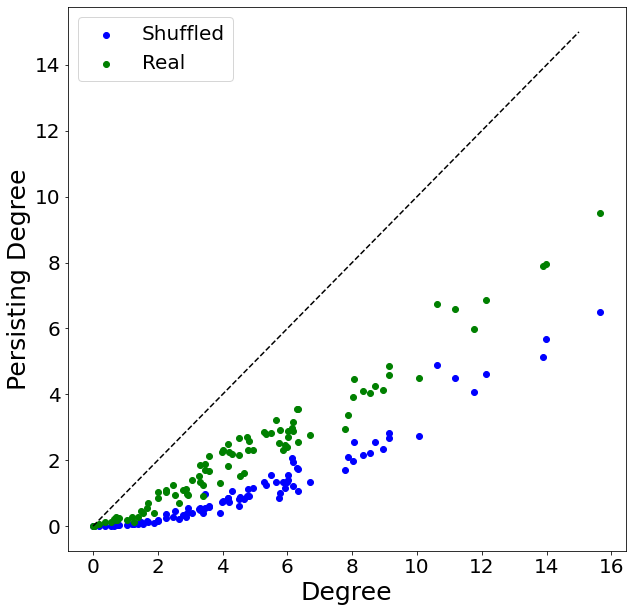

In [7]:
plt.figure(figsize=(10,10))

plt.scatter(x=pnt_likelihood_TCM.vec_k,y=vec_h_null/100 ,c='blue',label = 'Shuffled')

plt.scatter(x=pnt_likelihood_TCM.vec_k,y=pnt_likelihood_TCM.vec_h ,c='green',label = 'Real')

plt.plot([0, 15], [0, 15], ls="--", c="0")

plt.legend(fontsize=20)
plt.xlabel('Degree',fontsize=25)
plt.ylabel('Persisting Degree', fontsize=25)
plt.tick_params(axis='both', labelsize=20)  
plt.show()

### Here I compute the MSE for different segments and the eigenvalues for the Model with local memory

In [87]:
 def measured_autocorrelation(tgraph,tau):

    no_steps = len(tgraph.data)    
    no_nodes = len(tgraph.data[0][2].nodes()) 

    vec_h = np.zeros(no_nodes)        
    for i_step in range(no_steps+tau -1): 

        block_id, current_time , g0 = tgraph.data[ i_step%no_steps ]
        block_id, current_time , g1 = tgraph.data[ (i_step+tau)%no_steps ]
        for [n1,n2] in g0.edges():


            if g1.has_edge( n1,n2 ):
                vec_h[int(n1)] += 1.
                vec_h[int(n2)] += 1.

    vec_h /= float(no_steps+tau -1)

    h_ave = np.sum(vec_h)/len(vec_h)

    return np.asarray(vec_h),h_ave

In [88]:
class update_bjlambda:
    MIN_FITNESS = 1e-5 

    
    def __init__(self, tgraph, symmetric = True):
        self.verbose = False
        self.temp_graph = tgraph
        self.no_steps = len(self.temp_graph.data)
        self.no_nodes = len(self.temp_graph.data[0][2].nodes()) #int(tgraph.no_nodes) #
        
        self.fitness = np.ones( 2*self.no_nodes ,dtype=np.float64)
        
        self.symmetric = symmetric
        

        self.max_likelihood = -1e20

        self.B = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)
        self.J = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)
        self.lambda_minus = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)
        self.lambda_plus = np.zeros( (self.no_nodes,self.no_nodes),dtype=np.float64)

             
        self.compute(self.fitness)

        
    def compute(self, fitness):
        alpha = fitness[:self.no_nodes] 
        beta = fitness[self.no_nodes:] 
        
        for i in range(self.no_nodes):
            for j in range(i,self.no_nodes):
                ai = alpha[i]
                aj = alpha[j]
                bi = beta[i]
                bj = beta[j]
                
                self.B[i,j] = - 0.5 * (ai+aj+bi+bj)  / float(self.no_steps)
                self.B[j,i] = self.B[i,j]                
                self.J[i,j] = - 0.25 * (bi+bj)  / float(self.no_steps)
                self.J[j,i] = self.J[i,j]                


        lambda_term1 = np.cosh(self.B, dtype=np.float128)*np.exp(self.J, dtype=np.float128)
        lambda_term2 = np.sqrt( np.exp(2*self.J, dtype=np.float128)*np.sinh(self.B, dtype=np.float128)**2 + np.exp(-2*self.J, dtype=np.float128) , dtype=np.float128 )

        self.lambda_plus = lambda_term1 + lambda_term2
        self.lambda_minus = lambda_term1 - lambda_term2
    
        
        return self.lambda_plus,self.lambda_minus



def estimated_autocorrelation_TCM(tnet,x,y,tau):
    
    pnt = update_bjlambda(tnet,True)
    
    h_exp =  np.zeros( tnet.no_nodes )

    T = pnt.no_steps 

    g = [-T*np.log(ii) for ii in np.concatenate((x,y))]
    lambda_plus,lambda_minus = pnt.compute(g)  
    
    
    for i in range(pnt.no_nodes):
        for j in range(pnt.no_nodes):
            if i == j:
                continue

            root = np.sqrt(np.exp(-1*(np.log(y[i]) + np.log(y[j]))) + np.sinh(1/(2)*(np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))**2 )                   
            sinhB = np.sinh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))
            
            coshB = np.cosh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))

            e_2B = np.exp(-1 * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))
            e_B = np.exp(-1/2 * (np.log(x[i])+np.log(x[j]) +np.log(y[i]) +np.log(y[j])))

            eJ = np.exp(1/(4)*(np.log(y[i]) + np.log(y[j])))


            sigma_l_t = (sinhB) / ( 2*root) + 1/2 
            
            h_exp [i] += sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(lambda_minus[i,j]**tau*lambda_plus[i,j]**(T-tau) + lambda_plus[i,j]**tau*lambda_minus[i,j]**(T-tau) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) # N.T.L.


    h_ave = np.sum(h_exp)/len(h_exp)
    return h_exp,h_ave


In [89]:
alfa_rand = np.random.rand(92) 
beta_rand =np.random.rand(92) 


beta_random_link =np.random.rand(46*91) 
beta_random_global =np.random.rand(1) 

In [ ]:
#[36:45] #[77:99]  #[193:214]

In [119]:
input_TNC = data[36:45]

tnet_TNC = Utilities.TemporalNetworkLoaderSynt(input_TNC,0,len(input_TNC))

    
pnt_likelihood_local = PersistenceNetFitness(tnet_TNC)
pnt_likelihood_global = PersistenceNetFitnessGlobal(tnet_TNC)


likelihood_global = pnt_likelihood_global.solve(alfa_rand,beta_random_global)

likelihood_local = pnt_likelihood_local.solve(alfa_rand,beta_rand)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


In [120]:
y_local = pnt_likelihood_local.fitness_y
x_local = pnt_likelihood_local.fitness_x


x_global = pnt_likelihood_global.fitness_x
y_global = pnt_likelihood_global.fitness_y

y_global_list = [y_global[0]]*len(x_global)

y_global_list = np.asarray(y_global_list)

In [121]:
input_data_cm = data

tnet_cm = Utilities.TemporalNetworkLoaderSynt(input_data_cm,0,len(input_data_cm))

pnt_likelihood_CM = NaiveNetFitness(tnet_cm)

x_cm =  pnt_likelihood_CM.solve_eq()

`gtol` termination condition is satisfied.
Function evaluations 12, initial cost 1.1318e+04, final cost 2.1155e-15, first-order optimality 3.35e-09.
`gtol` termination condition is satisfied.


In [122]:
h_exp =  np.zeros( pnt_likelihood_CM.no_nodes )
         
for i_node in range( pnt_likelihood_CM.no_nodes ):
    for j_node in range( pnt_likelihood_CM.no_nodes ):
        if i_node == j_node: 
            continue
            
        prod = x_cm[i_node] * x_cm[j_node ]

        h_exp[ i_node ] += (prod / (1 + prod)) ** 2 

In [123]:
data_dyadic = data[36:86]

tnet_dyadic = Utilities.TemporalNetworkLoaderSynt(data_dyadic,0,len(data_dyadic))

pnt_likelihood_dyadic = PersistenceNetFitnesslinks(tnet_dyadic) 

pnt_likelihood_dyadic.solve(alfa_rand,beta_random_link)

/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:194: RuntimeWarning: overflow encountered in double_scalars
  t_sum_alfa += (T * (
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:198: RuntimeWarning: overflow encountered in power
  np.power(self.lambda_plus[i, j], T, dtype=np.float64) + np.power(
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:194: RuntimeWarning: invalid value encountered in double_scalars
  t_sum_alfa += (T * (
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:215: RuntimeWarning: overflow encountered in double_scalars
  t_sum_beta = (T * (
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:219: RuntimeWarning: overflow encountered in power
  np.power(self.lambda_plus[i, j], T, dtype=np.float64) + np.power(
/home/virginio.clemente/Versione finale codici TN/PersistenceNetFitnesslinks.py:215: RuntimeWarning: invalid 

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


41099.48326807731

In [124]:
n_nodes =  pnt_likelihood_dyadic.no_nodes

y_link = pnt_likelihood_dyadic.fitness_y 
y_matrix = np.zeros((n_nodes,n_nodes))


ij = 0
for i in range(n_nodes):
    for j in range(i):
        
        y_matrix[i,j] = y_link[ij]
        y_matrix[j,i] = y_matrix[i,j]

        ij +=1

In [129]:
x = pnt_likelihood_dyadic.fitness_x 

h_exp_link =  np.zeros( n_nodes )


T = pnt_likelihood_dyadic.no_steps
tau = 2



lambda_minus = pnt_likelihood_dyadic.lambda_minus 
lambda_plus = pnt_likelihood_dyadic.lambda_plus
for i in range(n_nodes):
    for j in range(n_nodes):
        if i == j:
            continue
          
        y_ij = y_matrix[i,j]
        root = np.sqrt(np.exp(-1*(np.log(y_ij) ), dtype=np.float128) + np.sinh(1/(2)*(np.log(x[i])+np.log(x[j], dtype=np.float128) +np.log(y_ij, dtype=np.float128) ))**2, dtype=np.float128 )                   
        sinhB = np.sinh(1/(2) * (np.log(x[i], dtype=np.float128)+np.log(x[j], dtype=np.float128) +np.log(y_ij, dtype=np.float128) ), dtype=np.float128)

        coshB = np.cosh(1/(2) * (np.log(x[i])+np.log(x[j]) +np.log(y_ij) ), dtype=np.float128)

        e_2B = np.exp(-1 * (np.log(x[i])+np.log(x[j]) +np.log(y_ij)), dtype=np.float128)
        e_B = np.exp(-1/2 * (np.log(x[i])+np.log(x[j]) +np.log(y_ij)), dtype=np.float128)

        eJ = np.exp(1/(4)*(np.log(y_ij, dtype=np.float128)), dtype=np.float128)

        sigma_l_t = (sinhB) / ( 2*root) + 1/2 


        h_exp_link [i] += sigma_l_t**2 + (1-sigma_l_t)*sigma_l_t*(lambda_minus[i,j]**tau*lambda_plus[i,j]**(T-tau) + lambda_plus[i,j]**tau*lambda_minus[i,j]**(T-tau) )/(lambda_minus[i,j]**T + lambda_plus[i,j]**T ) # N.T.L.


        

estimated_local,mean_l = estimated_autocorrelation_TCM(tnet_TNC,x_local,y_local,tau)

estimated_global,mean_g = estimated_autocorrelation_TCM(tnet_TNC,x_global,y_global_list,tau)
        
autocorrelazione_misurata,media = measured_autocorrelation(tnet_TNC,tau)

In [130]:
from sklearn.metrics import mean_squared_error

print( mean_squared_error(autocorrelazione_misurata, h_exp) ,' memory-less')

print( mean_squared_error(autocorrelazione_misurata,  estimated_local) ,' memory local')

print( mean_squared_error(autocorrelazione_misurata, estimated_global) ,' memory global')

print( mean_squared_error(autocorrelazione_misurata, h_exp_link) ,'memory dyadic')

8.739923760202695  memory-less
0.9068683964411406  memory local
1.1302978592876305  memory global
3.319243447540224 memory dyadic
